The intention of this notebook is to introduce you to the concepts needed for building a multimodal search engine. Starting off with a little theory, and ending off with an implementation of a practical system that can search between spoken and handwritten digits. Sections marked as "Optional" or "Advanced" are aimed at readers who want to learn a bit more or challenge themselves, but are by no means required for the tutorial.

# Before you code

If you're working in Colab, run this cell by clicking the play button next to it before you do anything else. This will take about 10 minutes to complete because we are installing all of the necessary packages as well as downloading the data needed to run this notebook from start to finish.

If you want to run this notebook in a Colab GPU instance, go to the Runtime menu above, then "Change runtime type" and select GPU, and then run the code in this section.

In [ ]:
!pip install torchfsdd
!pip install --upgrade torchaudio==0.9.0
!pip install --upgrade torchvision==0.10.0
!pip install pytorch-lightning
!pip install plotly-express
!pip install pytorch-metric-learning
!pip install lightning-bolts


!rm spectrograms -r
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!cp free-spoken-digit-dataset/utils ./utils -r
!mkdir spectrograms
!mkdir spectrograms/train
!mkdir spectrograms/validation

# Theoritical introduction to mutlimodal search using representation learning

Consider a world in which you are unable to recognize similar objects, events, or sounds. It will be total chaos. For example, when opening a door you know that you need to turn the handle, even if it isn't a style of handle that you have seen before. This is because you recognise the concept of a door and handle. If you didn't, you would have to learn how to open each door individually, without exploiting information that you have learnt in the past about other doors.

Fortunately, we are capable of accomplishing this. You might very well notice that, despite the fact that we are currently working in Google Colab, that the environment looks VERY similar to a Jupyter Notebook and you feel more at ease already. You accomplish this by noticing similarities between the two and then linking them together. You can already guess at certain functionality based on experiences with the other platform.

So, how can we train models to emulate this? This is what we'll attempt to cover in this notebook. How can we train our models to recognize similar concepts in one modality (vision) while also being able to recognize similar concepts in another modality (sound)? In the next section we'll look at the theory of representation learning, which is at the heart of being able to perform multimodal search.

## What is representation learning

When you read the line, "The sky is blue outside today," I'm sure you had a clear picture in your mind of the scene I described. You pictured a scene with good weather and possibly even heard some birds chirping. That line of text is a representation of that scene you just pictured, as well as the actual sky outside. It is a low dimensional depiction of that complicated image in that it just has 29 characters, including white space. Years of reading and gazing at the world allowed us to portray that image with this compressed data. So here we came to our first desirable characteristic, a representation should only contain the necessary information.

If you read the statement "The sky is red outside today," I am sure you envisioned a similar scene. Maybe it was a sunset, but the overall concept of the image in your head was probably simillar. If I have to ask if you think these two images of a red and blue sky are more comparable than the image from the statement "A mighty llama on a hill", you will agree that the skies are more similar. To put it another way, the more similar the representations are, the more similar the thing they represent is.

These two characteristics do not cover everything, but they should give you an idea of what we desire from representations. They should be similar to one another, and should contain only the necessary information. To make it easier for us to actually use these representations with computers, we adopt a vector of numbers rather than text. If we then train a decent model to take in a picture and output a vector representing the image, then the vectors of similar images should be similar to one another but different from disimilar images, and the vector should be of a lower dimension to push the model to discard worthless input.

<br/>![alttext](https://static.wixstatic.com/media/6f0a98_ed03fc02d23943549b6dc49412c4b08c~mv2.png/v1/fill/w_725,h_296,al_c,q_95/6f0a98_ed03fc02d23943549b6dc49412c4b08c~mv2.webp)*Example of calculating distances between three representations*<br/>

The image above depicts a basic example of how representation vectors can be interpreted. Imagine that Jonh and Alexander are rugby players, and Ben is a cricket player. Assume we've built a model that can take all of the players' body measurements and generate two-dimensional vector representations of the data. We plotted these vectors in the above figure to visualize them, and as expected, John and Alexander are closer to each other than Ben. This is mathematically demonstrated by calculating the distance between the vectors using a distance metric, such as the Euclidian or Cosine distance, as shown in the figure.

To summarize, representation learning is a term used to describe the modeling process in which we optimize a model to output a vector that will be similar for similar types of input and that can ignore non-important input features. In the following section, we'll go over some common methods for accomplishing this.

To give you an idea of the world we're moving into, we've included a gif of one of our Fluffy models, specifically a text model, learning over time how to generate representations that can summarize the different topics. Over time, points that are of the same class (unique colours in the plot) are grouped together.
<br/>

![alttext](https://static.wixstatic.com/media/6f0a98_f8cf2662a6fb4a4cb47deacceeeef98b~mv2.gif)

## Common methods

Training a representation engine differs from training a classification model. We are simply interested in learning the distribution of P(Y|X) for classification models, where your labels are given by $Y=\{y_1, y_2, ..., y_n\}$ and your input data is given by $X=\{\mathbf{x}_1,\mathbf{x}_1, ..., \mathbf{x}_n\}$. This is useful if you have a limited number of classes to which your data can belong, as you can simply go $\text{argmax}\space{P(Y=y|\mathbf{x})}$ for your input and then find similar x by assuming the similar classes are similar.

But how do you tell which two dogs are more similar from three dog images? We can't do it with models that are tuned for $P(Y|X)$. We'll need a model that can simulate the underlying distributions for $P(X|Y)$ or simply $P(X)$. Classification models will also be unable to generalize to unknown classes, necessitating the development of techniques based on unsupervised methods or the combination of traditional supervised methods and unsupervised methods.

These techniques fall into three different methods, **generative modelling** and **contrastive learning**


#### Generative modeling

In generative modeling, we are interested in learning the underlying data distribution of our data because this allows us to extract common patterns of similar objects, which we then use as representations. The space from which our data is generated is represented by the latent space. An example of how we can sample from the latent space to generate a new image (or any input type) is shown below .

![alttext](https://jmtomczak.github.io/blog/4/lvm_diagram.png)

A graphical representation of a latent variable model and a generative process. (Adapted from [Jakub Tomczak's](https://jmtomczak.github.io/blog.html) amazing [blog series](https://jmtomczak.github.io/blog.html)) *


<br/>



We are more interested in learning the latent representation of our data,  $\mathbf{z}$, which is sampled from the latent space, for our use cases. In other words, if we can determine $P(Z|X)$, we can use $p(z i|x i)$ to infer our representation. The intuition is that if we can find the hidden representations that generate the input data, these hidden representations will then describe the information needed to compare different datapoints. The Variational Autoencoder (VAE) architecture is one of the most commonly used to model this . The structure of the VAE is very similar to that of the Autoencoder, which is an encoder that takes an input and maps it to a lower dimensional vector, from which a decoder must be able to reconstruct the original input. However, with a VAE, the encoder does not simply compress the data, but also models the distribution of $P(Z|X)$, and the decoder then models the distribution of $P(X|Z)$. The figure below shows an example of this.


![alttext](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-17-at-11.31.15-PM.png) 

*High level overview of the VAE architecture. Taken form [Jeremy Jordans’](https://www.jeremyjordan.me/variational-autoencoders/) blog.*

<br/>

So, what now? We have an architecture concept, but how do we train it? First, forget about deep learning and focus on the top left figure in the image above, which is a probabilistic graph. Remind yourselve that we want to get $p(z|x)$ for our data in order to get good representations. The joint distribution is defined by the graph, namely $p(x, z) = p(x|z)p(z)$. In our case, we want $p(z|x)$, which we can rewrite as the function below thanks to Bayes. There are, however, a few issues with this. We don't know $p(z), and calculating $p(x)$ is computationally impossible because you have to sum over all latent variables.


<br/>

$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$

The good news is that we can approximate $p(z|x)$ rather than modeling it, by calculating $q(z|x)$. To see if our final approximation is good, we can compute the KL Divergence between the true posterior $p(z|x)$ and $q(z|x)$, which is given by the formula below. Because we want to minimize the KL divergence, the best approximation will be given by minimizing this function with  $q^*(z|x)$.

<br/>

$KL(q(z|x)||p(z|x))=\mathbf{E}_q[\log{q(z|x)}] - \mathbf{E}_q[\log{p(x,z)}]+\log{p(x)}$

<br/>

Again, we cannot compute $q^*(z|x)= \arg\min {KL(q(z|x)||p(z|x))} $ because $p(x)$ appears in the equation.  However, we can rewrite the equation in the following manner to obtain the evidence lower bound (ELBO). Because the KL divergence is always greater than or equal to zero, we can minimize it by increasing the ELBO.  If you might be a bit lost here on what the ELBO is, I refer you to another great blog writer [Matthew N. Bernstein](https://mbernste.github.io/posts/elbo/).

<br/>

$
KL(q(z|x)||p(z|x))=\mathbf{E}_q[\log{q(z|x)}] - \mathbf{E}_q[\log{p(x,z)}]+\log{p(x)} \\
\log{p(x)} = \mathbf{E}_q[\log{p(x,z)}] - \mathbf{E}_q[\log{q(z|x)}] + KL(q(z|x)||p(z|x))  \\
\log{p(x)} = ELBO + KL(q(z|x)||p(z|x)) \\
...\\
ELBO = \mathbf{E}_q[\log{p(x,z)}] - \mathbf{E}_q[\log{q(z|x)}] \\
ELBO = \mathbf{E}_{q}[\log{p(x|z)}] - KL(q(z|x)||p(z))
$


<br/>

That last line I made a massive jump, but there is not space to derive it entirley, but I can recommend this [video from Dr Ali Ghodsi](https://www.youtube.com/watch?v=uaaqyVS9-rM) if you are interested in the derivation. We can now approximate $\mathbf{E}_q[\log q(z|x)] $ utilizing our encoder network and $KL(q(z|x)||p(z))$ with our decoder network, where the encoder is parameterized by $\theta$ and the decoder by $\phi$. Because maximising a function is the same as minimizing its inverse, the loss function for our VAE that we want to optimize is:

$
L(\theta, \phi) = -ELBO \\
L(\theta, \phi) = KL(q_{\theta}(z|x)||p(z)) - \mathbf{E}_{q_\theta}[\log{p_\phi(x|z)}]
$

<br/>

This all appears to be very complicated right now, but we can make it much easier to understand intuitively. The KL divergence between our approximate network, which is our encoder, and the true prior $p(z)$ is the first term in our loss. Nothing prevents us from assuming the distribution of $p(z),$ so we can assume it is a Normal distribution. As a result, we can easily compute these values. The reconstruction error between the input data point and the reconstructed data point is denoted by the second term in our loss. If we then optimize this loss function, we will have an encoder that can approximate $p(z|x)$ and generate our input representations.

Please refer to the great blogs listed below for more information. This notebook focuses on discriminative methods and won't see more of this. 


*   [Jakub Tomczak](https://jmtomczak.github.io/blog/4/4_VAE.html)
*   [Jeremy Jordan](https://www.jeremyjordan.me/variational-autoencoders/)
*   [Jaan Altosaar](https://jaan.io/)
*   [Deepmind lecture slides (much more models and methods](https://storage.googleapis.com/deepmind-media/UCLxDeepMind_2020/L10%20-%20UCLxDeepMind%20DL2020.pdf)



#### Contrastive learning

In the previous section, we concentrated on determining the underlying latent space that generates our input data, $Z$. We can then sample latent representations from space for a given input by knowing the approximate posterior of $q(z|x)$, which is modelled by an encoder.

With contrastive learning though, we directly optimize our encoders to produce representation vectors that are similar and close to each other in some geometric space. Most of the time, this geometric space is Euclidian, and the distance between representations is calculated using Cosine similarity, Euclidian distance, or the dot product. There are various losses and methods for accomplishing this, but the general idea is the same in most cases.

Assume again we want to create a network that takes an image as input and generate similar representations for similar images. The most common way to do this right now is to take your images, crop each one into two separate images, and then augment each crop differently. The network will then be optimized to group together cropped images from the same image and push other images away. By doing so, you force the model to ignore irrelevant information and focus on the information in an image that is needed to bring similar images closer together.

The architecture for something like this is shown in the diagram below. The deep learning models depicted in the figure are actually just one model, and the weights of that model are what we update. There are a few methods for sampling data in order to train our neural networks. In one case, we attempt to force a contrast between data points sampled from different inputs, as shown in the figure below, whereas in another, we attempt to contrast inputs from known different classes.

The common contrastive methods are discussed in greater detail below.

![alttext](https://drive.google.com/uc?export=view&id=1MnD8f5cWNblv8foucjQLFDQuyR2HQvnL)
*Basic idea of contrastive learning.*

<br/>

##### Margin loss

The task is relatively simple in the case of margin loss. If we know that two inputs are from the same class/sample, we minimize the distance between the generated embeddings; otherwise, we maximize the distance.

Margin loss is typically classified into two types: pairwise margin loss and triplet margin loss.

First, we'll go over **pairwise margin loss**. It is essentially the idea depicted in the figure above, in which we can either crop the same image from a similar class and attract those embeddings, or we can use the label as our criterion and repel mountains from llamas for example. The loss function is shown below, where $z_i$ and $z_j$ are the model representation outputs and $y=1$ when class/sample $i=j$, i.e. positive pairs, and $0$ otherwise, with $d()$ representsing the distance between the vectors. Taking this into account,  we can see that when $y=1$, only the left side of the loss contributes, and when $y=0$, only the right side contributes.

The left section is straightforward; the closer the representations, the smaller the value and the less the model is penalized. On the right, we can see that we are only interested in distances between negative pairs that are greater than $\alpha$, the margin. This is due to the fact that we do not want to continue penalizing the model for results that are already good at being separated. The margin used here is critical, and it is from this that the technique gets its name. The greater the margin, the more difficult the task.

<br/>

$L_{pairwise} = (y)d(z_i, z_j) + (1-y)\max(0, \alpha-d(z_i-z_j))$

<br/>

With **triplet loss**, we apply the same principle, but instead of sampling pairs, we sample triplets. An anchor representation, $z_a$, a positive representation, $z_p$, and a negative representation, $z_n$ make up a triplet. The triplet loss is depicted below.

<br/>

$L_{triplet} = \max(0, \alpha+d(z_a, z_p)-d(z_a, z_n))$

<br/>

Here we see that the task is to get $d(z_a, z_p) < (d(z_a, z_n)+\alpha)$. Again, the margin is important in determining the difficulty of the task. It has been discovered that triplet loss outperforms pairwise loss in many cases, but only if the triplets are sampled correctly. The three types of negative pairs that can be sampled are shown below, namely easy, semi-hard, and hard. Obviously, easy triplets should not be mined because they add nothing, but using semi-hard and hard negatives results in good training. More detailed information is available in [Olivier Moindrots'](https://omoindrot.github.io/triplet-loss) blog.

<br/>
<img src="https://gombru.github.io/assets/ranking_loss/triplets_negatives.png" width="300"/>

*Representation of three "types of negatives" for an anchor and positive pair. Taken from [Olivier Moindrots'](https://omoindrot.github.io/triplet-loss) blog*


Also, there is no reason to discard labels if you have them for your data when training your models. One of our favorite things to do at ByteFuse  when we have labels is to  implement Triplet Entropy loss. Here we combine the triplet loss function with cross-entropy. So, in essence, we are training our model to classify and separate, which results in better representations for known classes. More information can be found [here](https://arxiv.org/abs/2012.03775v1).

<br/>

##### SimCLR

The NT-Xent (Normalized Temperature-scaled Cross ENTropy) loss presented in the [SimCLR](https://arxiv.org/abs/2002.05709) paper, with the loss shown below, is widely used. In the equation, $\text{sim}$ is the dot product of the $l_2$ normalized vectors, or, to put it another way, the cosine similarity of two vectors. The greater the similarity, the higher the output. SimCLR is based on a very simple concept. Crop an image in two different random ways, augment these crops differently, and pull these two image representations together while repeliling the representations of other images.

<br/>

$
\begin{aligned}
L_{nt-xent} = -\log\frac{\exp{(\text{sim}(z_i, z_j) / \tau)}}{\sum^{2N}_{k=1; k \neq i}\exp{(\text{sim}(z_i, z_k) / \tau)}}
\end{aligned}
$

<br/>

To interpet this loss, remember what we want to achieve.  We only want $\text{sim()}$ to be high for vectors obtained from cropped images of the same image, i.e. vectors $z_i$ and $z_j$. If our model is correct, then $\text{sim}(z_i, z_j)$ is large (because they are from the same image), causing the value inside the log function to be large and resulting in a larger negative loss value. As a result of optimizing this loss value, the model will learn how to map an image from the high dimensional pixel space to the lower dimensional representation space, while attempting to maximize $\text{sim}(z_i, z_j)$. The SimCLR process is depicted below (which is a bit different from the concept in the figure above).

<img src="https://sthalles.github.io/assets/contrastive-self-supervised/cover.png" width="750"/>

*SimCLR visualized, taken from [Thalles Silva](https://sthalles.github.io/simple-self-supervised-learning/) blog.
italicized text*

<br/>

We only briefly discussed augmentations, but they are an important part of representation learning. Augmentations are used to regulate our models because they make it more difficult to find similar features because the augmentations distort the input. We can add noise to images, change the color, flip the image, and do pretty much anything else you can think of. A comprehensive list of Pytorch augmentations can be found [here](https://pytorch.org/vision/stable/transforms.html).



---



Another method, called contrastive predictive coding, uses an autoregressive model to summarize all latent variables up to a timestep in one vector $c_t$, after which the future latent variables $z_{t+k}$ from the real signal and other signals are compared to ensure the current encodings from the model hold up for future predictions. This is somewhat advanced and not covered here, but if you want to learn more, you can read the original paper [here](https://arxiv.org/pdf/1807.03748v2.pdf)



## Taking this Multimodal

So we have methods that can take a single modality and generate a representation that allows me to find similar inputs by using a distance function between representations. But how do I search for images by using text? Or search sounds with spoken queries? It might be simpler than you think.

There are a variety of other ways to accomplish this, but the most effective method, and one that we use at ByteFuse a lot, is to project representations from each modality into a shared space where all modalities can exist side by side. The diagram below provides a high-level overview of how this is done.

<br/>
<img src="https://drive.google.com/uc?export=view&id=19lfzFlQmxQ6-ADN-6RlFeVzDOp7pxEre" width="500"/>

*High level overview of the multimodal Fluffy architecture implemented at ByteFuse*

The projection layers for each modality is one of the most important features in the architecture above, and ultimately what allows multimodal search. The first and simplest method for creating these projection layers is to simply use a margin loss, as described above. Rather than just using pairs from the same modality, we sample pairs from different modalities and train our projection layers to bring them closer together. See the following example:

<br/>
<img src="https://gombru.github.io/assets/ranking_loss/triplet_loss_multimodal.png" width="700"/>

*Example of using triplet loss across modalites*

OpenAI recently introduced [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020), or the more popular name, [Clip](https://openai.com/blog/clip/). The overall training procedure is depicted in the diagram below. Here, they took a text encoder and an image encoder and fed them data containing text paired with an image. Then, for each combination of text and image pairs, the dot product is calculated to form a similarity matrix. They then arrange the similarity matrix, as shown below, where the diagonal of the matrix represents the true combination's dot products. The softmax function is then applied row by row and column by column, converting each row and vector into a probability vector. Because we know the correct combination is on the diagonal, we can apply cross-entropy to each row and column and make the label 1 for the diagonal and 0 for the rest of the positions. The model is then trained to correctly predict the correct combination.

<br/>

<img src="https://drive.google.com/uc?export=view&id=18NW68QeMBb_9bQmx7rV_RVyWbgtGv2Iv" width="700"/>

*CLIP pre-trains an image encoder and a text encoder to predict which images were paired with which texts in a dataset*

Despite the fact that Open-AI developed this method to train a zero-shot model, a side effect of training in this manner is that two projection layers have learned to create representations that produce larger dot products for similar inputs.

We can train projection layers for all modalities (given the right data) and create a massive database of all the data we (or you) have available and their corresponding representations using the techniques described above. If we get a new  input, all we have to do is feed it through the appropriate representation model and projection layer, and depending on which modality we want to return, we just do a distance search over the database of embeddings and return the closest $N$ representations. A high-level overview of how this would work in practice is provided below.

<br/>

<img src="https://drive.google.com/uc?export=view&id=1n7D1nO0MCyEaGZ8iDGLVdV51x0y3pHyv" width="800"/>

*A high level overview of mutlimodal search in practice.*

Hopefully you're not too tired by now, because we're about to put what we've learned into action! We will develop a system that can search using both voice and visual input.

# Importing required packages

In [ ]:
import IPython.display as ipd
import os
from shutil import copyfile
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import scipy.io.wavfile as wav
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly_express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision

# from pl_bolts.models.autoencoders.components import resnet18_decoder, resnet18_encoder
from pytorch_metric_learning import miners, losses

from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.seed import seed_everything

# Using the functions written by the FSSD team (https://github.com/Jakobovski/free-spoken-digit-dataset)
from utils.fsdd import FSDD

import warnings

warnings.filterwarnings('ignore')

# Helper functions

In [ ]:
# A few util functions used throughout notebook

def ignore_none_collate_fn(batch):
    '''
    Collate function to be used with torch.Dataloader if 
    you wish for the dataloader to ignore None that is returned 
    from dataset itarator and collect a new sample.
    '''
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

def wav_to_spectrogram(audio_path,
                       save_path,
                       spectrogram_dimensions=(64, 64),
                       noverlap=16,
                       cmap='gray_r'):

    sample_rate, samples = wav.read(audio_path)

    fig = plt.figure()
    fig.set_size_inches((spectrogram_dimensions[0] / fig.get_dpi(), spectrogram_dimensions[1] / fig.get_dpi()))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.specgram(samples, cmap=cmap, Fs=2, noverlap=noverlap)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(save_path, bbox_inches="tight", pad_inches=0)
    plt.close(fig)


def draw_mnist_subplots(data):

    plt.subplot(1, 4, 1)
    plt.title(data[0][1])
    plt.imshow(data[0][0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title(data[1][1])
    plt.imshow(data[1][0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title(data[2][1])
    plt.imshow(data[2][0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(data[3][1])
    plt.imshow(data[3][0], cmap='gray')
    plt.axis('off')
    plt.show()
    
    
def plot_embeddings_unimodal(plot_data):
    embeddings = []
    digits = []

    for data in plot_data:
        embedding, digit = data[0], data[1]
        digits.extend(digit)

        for emb in embedding:
            embeddings.append(emb.detach().cpu().numpy())

    digits = [str(int(i.cpu())) for i in digits]

    # tsne = PCA(2, verbose=4)
    embeddings = PCA(2).fit_transform(embeddings)
    embeddings = np.array(embeddings)

    df = pd.DataFrame({
        'comp1': embeddings[:,0],
        'comp2': embeddings[:,1],
        'digits': digits,
    })

    df = df.sort_values('digits')
 
    fig = px.scatter(x=df.comp1.values,
                     y=df.comp2.values,
                     color=df.digits.values)
    fig.show()
    # ipd.display(fig)
    # ipd.clear_output(wait=True)
    
    
def plot_embeddings_multimodal(plot_data):

    image_embeddings = []
    audio_embeddings = []
    image_digits = []
    audio_digits = []

    for data in plot_data:
        image_embedding, audio_embedding, image_digit, audio_digit = data[0]['image_embeddings'], data[0]['audio_embeddings'], data[1], data[2]
        image_digits.extend(image_digit)
        audio_digits.extend(audio_digit)

        for emb in image_embedding:
            image_embeddings.append(emb.detach().cpu().numpy())

        for emb in audio_embedding:
            audio_embeddings.append(emb.detach().cpu().numpy())

    meta = ['MNIST'] * len(image_embeddings) + ['FSSD'] * len(audio_embeddings)
    embeddings = np.concatenate((image_embeddings, audio_embeddings))
    digits = image_digits + audio_digits
    digits = [str(int(i.cpu())) for i in digits]

    # tsne = PCA(2, verbose=4)
    embeddings = PCA(2).fit_transform(embeddings)
    embeddings = np.array(embeddings)

    df = pd.DataFrame({
        'comp1': embeddings[:,0],
        'comp2': embeddings[:,1],
        'digits': digits,
        'meta': meta
    })

    df = df.sort_values('digits')
 
    fig = px.scatter(x=df.comp1.values,
                     y=df.comp2.values,
                     color=df.digits.values,
                     symbol=df.meta.values)
    fig.show()
    # ipd.display(fig)
    # ipd.clear_output(wait=True)

# Creating our multimodal dataset


In [ ]:
# helper class from the creators of fsdd
fsdd = FSDD(data_dir='free-spoken-digit-dataset/recordings')

# convert and save all audio as spectrogram to speed up training process
for digit in tqdm(range(10)):
    os.mkdir(f'./spectrograms/train/{digit}')
    os.mkdir(f'./spectrograms/validation/{digit}')
    for file in fsdd.recording_paths[digit]:
        split = 'train' if int(file.split('_')[-1].split('.')[0]) > 4 else 'validation'
        wav_to_spectrogram(file, f'./spectrograms/{split}/{digit}/{file.split("/")[-1].replace("wav", "png")}')

To gain an intuitive understanding of the techniques, we will begin with a Hello World setup. Our task will be to develop a system that can freely search between spoken and handwritten digits. This will be done using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and the [FSDD](https://github.com/Jakobovski/free-spoken-digit-dataset) dataset. Below is a brief overview of each dataset and how we prepare it for use by our models.

## MNIST dataset

The Modified National Institute of Standards and Technology database (MNIST) is a large collection of handwritten digits. It has a 60,000-example training set and a 10,000-example test set. It is a subset of the larger NIST Special Database 3 (digits written by US Census Bureau employees) and Special Database 1 (digits written by high school students), both of which contain monochrome images of handwritten digits. In a fixed-size image, the digits have been size-normalized and centered. As a result of the normalization algorithm's anti-aliasing technique, the resulting images have grey levels.

The dataset's examples are shown below. These images differ from other images encountered in that they only have one image channel, rather than the standard three. As a result, each input image for the model will be in the shape (1x28x28).

P.S. If this is your first time working with the MNIST dataset, please accept my greetings. You have successfully completed the first stage of your journey to computer vision and deep learning and encountered the first rite of passage.

![alttext](https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png)

## Free Spoken Digits Dataset

A simple audio/speech dataset consisting of 8kHz wav files containing recordings of spoken digits. The recordings have been trimmed so that there is almost no silence at the beginning and end. The dataset currently consists of only 6 speakers, 3000 recordings (50 from each speaker), and only English speakers. Some sample audio outputs are provided below.

In [ ]:
print('Example of someone saying 5')
ipd.Audio('./free-spoken-digit-dataset/recordings/5_george_5.wav')

Example of someone saying 5


In [ ]:
print('Example of someone saying 5')
ipd.Audio('./free-spoken-digit-dataset/recordings/2_george_2.wav')

Example of someone saying 5


In [ ]:
print('Example of someone saying 5')
ipd.Audio('./free-spoken-digit-dataset/recordings/9_george_9.wav')

Example of someone saying 5


Before we go any further, it's important to talk about how we'll transform the audio for our models. When it comes to audio, there are usually only two options. You can either use the raw wave form, which is plotted in the code below.

The other option, which we will use, is to generate a spectrogram of the waveform. The overall process of generating a spectrogram is beyond the scope of this notebook, but it can be thought of as transforming raw audio data into a structure with fewer dimensions, almost like an audio fingerprint. We do this by s liding a Discrete Fourier Transform (DFT) window over the signal that then creates frames that describe the frequency characteristics of the signal within that window (more and MUCH BETTER information [here](https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0)). For the time being, think of this process as converting audio into an image representation of it. We've already converted all of your audio files into spectrograms for you (if you have run all the code above).

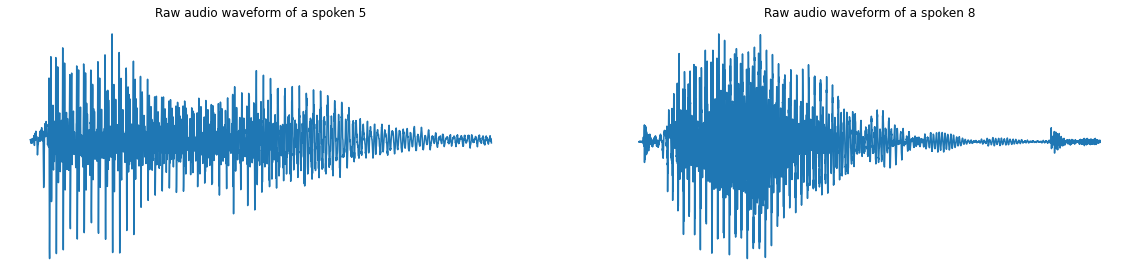

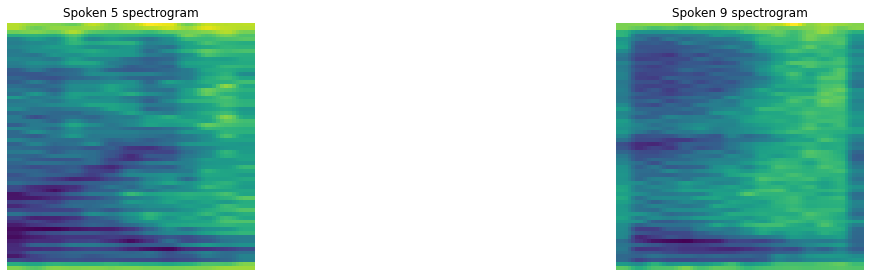

In [ ]:
# reading in a piece of audio
audio5, sample_rate = torchaudio.load('./free-spoken-digit-dataset/recordings/5_george_5.wav')
audio8, sample_rate = torchaudio.load('./free-spoken-digit-dataset/recordings/8_george_8.wav')

spec5 = torchvision.io.read_image('./spectrograms/train/5/5_george_5.png')
spec8 = torchvision.io.read_image('./spectrograms/train/8/8_george_8.png')

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title("Raw audio waveform of a spoken 5")
plt.plot(audio5[0])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Raw audio waveform of a spoken 8")
plt.plot(audio8[0])
plt.axis('off');

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.title("Spoken 5 spectrogram")
plt.imshow(spec5[0])
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Spoken 9 spectrogram")
plt.imshow(spec8[0])
plt.axis('off');


## Creating a pytorch-lighting datamodule

We will primarily use Pytorch Lighting throughout this notebook because it abstracts away a lot of the repetitive Pytorch code while also allowing us to better structure our code. More information is available at their [website](https://www.pytorchlightning.ai/).

As stated in the theory, we need a method of structuring our input so that we know which digit representations we are working with so that we can create new labels or mine for triplet pairs to do contrastive learning between modalities. Because both of our datasets are labeled, we can create a Pytorch iteratable dataset that samples from both the MNIST and FSDD datasets at the same time and returns a spectrogram (our speech) with its corresponding label and a sampled MNIST digit with its corresponding label.

<br/>

<img src="https://drive.google.com/uc?export=view&id=1FKtHuUyEDH_HQdfthlrNN42hdA8r2v22" width="900"/>

<br/>

Our sampling strategy is also depicted above. As you can see, the concept is quite simple. Then we build a Pytorch dataloader that can combine our multimodal samples into a single batch that we can use to train our networks. This dataloader can then be looped, and it will continue to provide us with batches of data until we have sampled all of our data. Below is the code for our sampler, which returns one sample, as well as our Pytorch lighting data module, which contains our training and validation dataloaders.

The sampler is the *AudioAndImageDataset* class, and the datamodule is the *MnistAudioImageDataModule* class that comes after that. If you're curious about how the data was downloaded and split into train and validation sets for FSDD, check out the code in the "Creating our multimodal dataset" section above. For the time being, this is unimportant, but familiarize yourself with it if you want to see how it can be applied to new projects.

In [ ]:
class AudioAndImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataset, audio_dataset):

        self.image_dataset = image_dataset
        self.audio_dataset = audio_dataset

        self.len_image_dataset = len(self.image_dataset)
        self.len_audio_dataset = len(self.audio_dataset)
        self.max_len = max([self.len_image_dataset, self.len_audio_dataset])

    def __getitem__(self, i):

        if i > self.len_image_dataset - 1:
            image_i = random.choice(list(range(self.len_image_dataset)))
            image, image_label = self.image_dataset[image_i]
        else:
            image, image_label = self.image_dataset[i]

        if i > self.len_audio_dataset - 1:
            audio_i = random.choice(list(range(self.len_audio_dataset)))
            audio, audio_label = self.audio_dataset[audio_i]
        else:
            audio, audio_label = self.audio_dataset[i]

        return image, audio, image_label, audio_label

    def __len__(self):
        return self.max_len

In [ ]:
class MnistAudioImageDataModule(LightningDataModule):
    def __init__(self,
                 mnist_image_size=28,
                 fsdd_image_size=64,
                 batch_size=64,
                 num_workers=4):

        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers

        audio_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((fsdd_image_size, fsdd_image_size)),
            torchvision.transforms.Normalize((0.4729), (0.1477)), 
            # images are save with 3 repeating channels, but we only want 1 dim
            lambda image: image[0].unsqueeze(0)
        ])

        image_train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((mnist_image_size, mnist_image_size)),
            torchvision.transforms.Normalize(mean=(0.1307), std=(0.3081))
        ])

        image_val_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Resize((mnist_image_size, mnist_image_size)),
            torchvision.transforms.Normalize(mean=(0.1307), std=(0.3081))
        ])

        self.audio_train_set = torchvision.datasets.ImageFolder(
            root='./spectrograms/train/', transform=audio_transforms)
        self.audio_val_set = torchvision.datasets.ImageFolder(
            root='./spectrograms/validation/', transform=audio_transforms)

        self.mnist_train_set = torchvision.datasets.MNIST(
            train=True,
            root='./mnist/',
            download=True,
            transform=image_train_transforms)
        self.mnist_val_set = torchvision.datasets.MNIST(
            train=False,
            root='./mnist/',
            transform=image_val_transforms
        )

    def setup(self):
        self.train_data = AudioAndImageDataset(self.mnist_train_set,
                                               self.audio_train_set)
        self.val_data = AudioAndImageDataset(self.mnist_val_set,
                                             self.audio_val_set)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_data,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=self.num_workers,
            collate_fn=ignore_none_collate_fn,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_data,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
            collate_fn=ignore_none_collate_fn,
        )

Doing the exercises below will give you a better intuition for how the Pytorch code works and the augmentation steps.

### Exercises

1. Take the MNIST dataset created above, sample one image from it, and plot it using matplotlib.
2. Now, take that same image and apply any torchvision transformation to it. Plot the transformed image again to see how it changes the image.
3. Create a transformation process (using torchvision.transforms.Compose) that performs at least three different transformations.
4. See if you can then add these transformations to the **image train transforms** process in the datamodule above.

If you want to take it a step further, you can learn about torchaudios' transforms [here](https://pytorch.org/audio/stable/transforms.html) and see how you might be able to apply them to our spectrograms.

# Building our architectures

Our first step has now been completed. We've built our dataset and dataloader, which will return a set of images and spectrograms along with their corresponding labels. Step 2 requires us to create models that can tranform our data  (either a 1x28x28 image or a 1x64x64 spectrogram).

Let us begin with our image model. We do not need cutting-edge models because the data contains relatively simple distributions that we must learn. We can create a small CNN that can slide over the image and extract the features we need. For more information on how CNNs work, I recommend [Ujjwal Karn's](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) brilliant blog post, in which he describes the basic building blocks of a CNN.

The architecture developed for this project is shown below (those of you who are familiar with deep learning history may notice an uncanny resemblance to the [LeNet](https://en.wikipedia.org/wiki/LeNet) architecture). You'll notice that we return both the embeddings and the logits of the network, as if we were constructing a classification network. This is done on purpose so that you can use whatever loss function you want. For instance,  Triplet Entropy Loss requires both logits and embeddings. If you only use the embedding layer and not the output layer in your loss during training, nothing will change because the gradient will never pass through the logits. So it is safe to have that layer there when it is not used.


We can reuse the same architecture and replace the first fully connected layer size with the correct dimension because our spectrograms follow the same overall structure as our MNIST images. This size is 256 for MNIST images and 2704 for our spectrograms. That is, assuming you do not change the convolutional layer.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, fc1_size, embedding_size=128):
        super().__init__()

        # our in channel here are 1 because of our input size 1x28x28
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5,
                               stride=1)
        
        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5,
                               stride=1)

        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.pool2 = nn.AvgPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(fc1_size, 512)  
        self.fc2 = nn.Linear(512, 512)

        self.encoding_layer = nn.Linear(512, embedding_size)
        self.output_layer = nn.Linear(embedding_size, 10)

        self.activation = F.relu 

    def forward(self, x):

        x = self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.conv2(x)))

        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))

        encoded_x = self.encoding_layer(x)

        # most tasks require normalization and it good practice to use normalized embeddings
        encoded_x_normalized = F.normalize(encoded_x, p=2, dim=1)

        logits = self.output_layer(encoded_x)

        return logits, encoded_x_normalized

Another critical step is to design our projection layer architecture, which will allow us to bring our representations into the same space. This can be anything, but for the time being, let's assume it's just a standard MLP architecture, with only fully connected layers.

Before we proceed, let us first practice building this architecture.


## Exercises

1. Create your own projection head using the ProjectionHead class template. The following are the input parameters:

> The input dimension is encoded dim. This will be the same size as the encoding layer in our models. The embedding size is the size of the final output representation that will be used to compare across modes. Try to keep it to a power of two.

2. When we are finished, come back and further play with these architectures and see if you can design your own network as well.

In [ ]:
# BUILD OWN PROJECTION HEAD
class ProjectionHead(nn.Module):
    def __init__(
        self,
        encodeded_dim=512,
        embedding_size=512,
    ):
        super().__init__()
        # DEFINE YOUR LAYERS HERE
        self.layer_norm = nn.LayerNorm(embedding_size)
    
    def forward(self, x):
        # WRITE CODE TO PROCESS X HERE

        # return this output, it expects an input with dimension of embedding size
        x = self.layer_norm(x)
        return x

# Creating our loss functions


We will only use Triplet Loss in this notebook (as well as our little inhouse Triplet Entropy Loss). We will primarily use [Pytorch Metric Learning](https://kevinmusgrave.github.io/pytorch-metric-learning/). This package performs all of the mining for us and also provides distance metrics and loss functions.

We created the following losses below:

1. A basic triplet loss module implementation that accepts as input generated embeddings as well as a label associated with the embedding. These labels can be either the actual labels of the data, such as the labels of our MNIST images, or they can be calculated on the fly to show which embeddings are connected in some way and should be pulled closer together. As a result, this implementation will bring embeddings with the same labels closer together while pushing others away.
2. The particular multimodal triplet loss that will be employed in this notebook. It accepts dictionary entries as input (created in our Pytorch Lighthing module). Our networks are then optimized to bring image and audio embeddings with the same label closer together.
3. Finally, there is a notebook-specific implementation of Triplet Entropy Loss, which simultaneously optimizes our models to predict the correct class while also bringing the representations closer together. Please keep in mind that this loss can only be applied to datasets with labelled examples.

In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=.5):
        super().__init__()
        self.triplet_miner = miners.TripletMarginMiner(margin=margin, type_of_triplets='semihard')
        self.triplet_loss_fn = losses.TripletMarginLoss(margin=margin,
                                                        swap=False)

    def forward(self, embeddings, labels):

        triplets = self.triplet_miner(embeddings, labels)
        loss = self.triplet_loss_fn(embeddings, labels, triplets)
        return loss

In [ ]:
class MultiModalTripletLoss(nn.Module):
    def __init__(self, margin=.5):
        super().__init__()
        self.triplet_miner = miners.TripletMarginMiner(
            margin=margin, type_of_triplets='semihard')
        self.triplet_loss_fn = losses.TripletMarginLoss(margin=margin,
                                                        swap=False)

    def forward(self, embeddings_and_labels):

        image_embeddings, audio_embeddings = embeddings_and_labels['image_embeddings'], embeddings_and_labels['audio_embeddings']
        image_labels, audio_labels = embeddings_and_labels['image_labels'], embeddings_and_labels['audio_labels']

        embeddings = torch.cat([image_embeddings, audio_embeddings], dim=0)
        labels = torch.cat([image_labels, audio_labels], dim=0)

        triplets = self.triplet_miner(embeddings, labels)
        loss = self.triplet_loss_fn(embeddings, labels, triplets)
        return loss

In [ ]:
class MultiModalTripletEntropyLoss(nn.Module):
    def __init__(self,
                 cel_weigth_tensor=None,
                 margin=0.5,
                 triplet_type='semihard',
                 cel_weigth=1,
                 te_weight=1):
        super().__init__()

        self.margin = margin
        self.cel_weight = cel_weigth
        self.te_weight = te_weight
        self.triplet_type = triplet_type
        self.triplet_miner = miners.TripletMarginMiner(margin=self.margin, type_of_triplets=self.triplet_type)
        self.triplet_loss_fn = losses.TripletMarginLoss(margin=self.margin,
                                                        swap=False)

        if not cel_weigth_tensor is None:
            self.cel_weight_tensor = cel_weigth_tensor
            self.cross_entropy_loss_fn = nn.CrossEntropyLoss(
                weight=cel_weigth_tensor)
        else:
            self.cross_entropy_loss_fn = nn.CrossEntropyLoss()

    def forward(self, embeddings_and_labels):

        image_logits, audio_logits = embeddings_and_labels['image_logits'], embeddings_and_labels['audio_logits']
        image_embeddings, audio_embeddings = embeddings_and_labels['image_embeddings'], embeddings_and_labels['audio_embeddings']
        image_labels, audio_labels = embeddings_and_labels['image_labels'], embeddings_and_labels['audio_labels']

        embeddings = torch.cat([image_embeddings, audio_embeddings], dim=0)
        logits = torch.cat([image_logits, audio_logits], dim=0)
        labels = torch.cat([image_labels, audio_labels], dim=0)

        # calculate triplet loss
        triplets = self.triplet_miner(embeddings, labels)
        triplet_loss = self.triplet_loss_fn(embeddings, labels, triplets)

        # calculate cosine-entropy loss
        cross_entropy_loss = self.cross_entropy_loss_fn(logits, labels)

        loss = self.cel_weight * cross_entropy_loss + self.te_weight * triplet_loss
        return loss

Next, we'll train our models. However, there are many more methods than the three listed above. Let's do the exercises listed below to become more at ease with everything.

## Exercises

1. Implement pair wise margin loss using Pytorchs' [CosineEmbeddingLoss](https://pytorch.org/docs/stable/generated/torch.nn.CosineEmbeddingLoss.html) module.
2. If you're feeling brave, create your own triplet mining function that takes in your labels and embeddings and returns only semi-hard or hard triplets.

# Training our models

The important parts have been completed. We have data, model architectures, and loss functions that need to be optimized. The only thing left to do is train our model. We will use the Pytorch lightings' [trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) to accomplish this. This trainer accepts our training and validation data, as well as our lighting module, and trains the model for us.

We begin by training two unimodal models, then show how much better search across modalities is when the models are trained together and with a projection layer.

## Unimodal training

Here's our first PL module example. This module implements all of the steps that would normally be written for vanilla Pytorch. There is a training step and a validation step, as you can see. Both of these functions indicate what happens when the model receives a batch during the training or validation phases. The optimizer that will be used during training is configured in configure optimizers. For the time being (but please expirment more on this), we will only use the Adam optimizer.

If you want to see how to reduce the dimensionality of the representations to only two dimensions to plot them on a figure so we can inspect how the models work, the plotting function is also hidden behind the "Helper functions" section. For those who are interested, we are using Principal Component Analysis (PCA) to reduce the dimensionality (https://en.wikipedia.org/wiki/Principal component analysis). When plotting, this function also overwrites the current cell's output, so we lose the pytorch lighting progress bar, so just be patient and wait for an update.

The PL module for our audio encoder is shown below, with the image encoder having the same structure but simply using the data return from our datasets differently.

In [ ]:
class AudioEncoder(LightningModule):
  def __init__(self, audio_encoder, loss_func, lr=1e-3):
    super().__init__()
    self.save_hyperparameters()

    self.audio_encoder = audio_encoder
    self.lr = lr

    self.loss_func = loss_func

  def forward(self, audio):
    audio_logits, audio_embeddings = self.audio_encoder(audio) if audio is not None else None
    return audio_logits, audio_embeddings

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    _, audio, _, audio_labels = train_batch
    audio_logits, audio_embeddings = self(audio)
    loss = self.loss_func(audio_embeddings, audio_labels)

    self.log(f'train_loss', loss, on_epoch=True, on_step=True)
    
    # The loss we retun here will be used by our optimizer configured in configure_optimizers
    # to update the weights of our model stored in self.audio_encoder.parameters()
    return loss

  def validation_step(self, val_batch, batch_idx):
    _, audio, _, audio_labels = val_batch
    audio_logits, audio_embeddings = self(audio)
    loss = self.loss_func(audio_embeddings, audio_labels)

    self.log(f'valid_loss', loss, on_epoch=True, prog_bar=True)

    # usually in the validation step you do not return anything, but we want to plot our embeddings
    return [audio_embeddings, audio_labels]

  def validation_epoch_end(self, plot_data):
    plot_embeddings_unimodal(plot_data)


class ImageEncoder(LightningModule):
  def __init__(self, image_encoder, loss_func, lr=1e-3):
    super().__init__()
    self.save_hyperparameters()

    self.image_encoder = image_encoder
    self.lr = lr

    self.loss_func = loss_func

  def forward(self, image):
    image_logits, image_embeddings = self.image_encoder(image) if image is not None else None
    return image_logits, image_embeddings

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
    return optimizer

  def training_step(self, train_batch, batch_idx):
    image, _, image_labels, _ = train_batch
    image_logits, image_embeddings = self(image)
    loss = self.loss_func(image_embeddings, image_labels)

    self.log(f'train_loss', loss, on_epoch=True, on_step=True)
    return loss

  def validation_step(self, val_batch, batch_idx):
    image, _, image_labels, _ = val_batch
    image_logits, image_embeddings = self(image)
    loss = self.loss_func(image_embeddings, image_labels)

    self.log(f'valid_loss', loss, on_epoch=True, prog_bar=True)
    return [image_embeddings, image_labels]

  def validation_epoch_end(self, plot_data):
    plot_embeddings_unimodal(plot_data)

We've written two very simple functions that simply abstract a portion of the repeating code. You can experiment with different embedding sizes, learning rates, loss functions, and the number of epocs using these functions and their parameters. Remember that, for the time being, the only loss function that will work is the TripletLoss function defined above, unless you have already implemented your own losses.

In [ ]:
def train_and_return_audio_model(embedding_size, learning_rate, loss_func, n_epochs=5, batch_size=64):
  seed_everything(42)

  audio_encoder = Encoder(fc1_size=2704, embedding_size=embedding_size)
  lr = learning_rate
  loss_func = loss_func

  data = MnistAudioImageDataModule(num_workers=4, batch_size=batch_size)
  data.setup()

  model = AudioEncoder(audio_encoder=audio_encoder,
                            loss_func=loss_func,
                            lr=lr)

  trainer = Trainer(
      gpus=1 if torch.cuda.is_available() else 0, 
      max_epochs=n_epochs, 
      deterministic=True
  )

  # fit the model
  trainer.fit(model, data)

  return model


def train_and_return_image_model(embedding_size, learning_rate, loss_func, n_epochs=5, batch_size=64):
  seed_everything(42)

  image_encoder = Encoder(fc1_size=256, embedding_size=embedding_size)
  lr = learning_rate
  loss_func = loss_func

  data = MnistAudioImageDataModule(num_workers=4, batch_size=batch_size)
  data.setup()

  model = ImageEncoder(image_encoder=image_encoder,
                        loss_func=loss_func,
                        lr=lr)

  trainer = Trainer(
      gpus=1 if torch.cuda.is_available() else 0, 
      max_epochs=n_epochs, 
      deterministic=True
  )

  # fit the model
  trainer.fit(model, data)

  return model

In [ ]:
# # here now train our own unimodal speech model

unimodal_speech = train_and_return_audio_model(2
    embedding_size=128,
    learning_rate=1e-3,
    loss_func=TripletLoss(), 
    n_epochs=2)

Global seed set to 42


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | audio_encoder | Encoder     | 1.7 M 
1 | loss_func     | TripletLoss | 0     
----------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.869     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# # here now train our own unimodal image model

unimodal_image = train_and_return_image_model(
    embedding_size=128,
    learning_rate=1e-3,
    loss_func=TripletLoss(), 
    n_epochs=2)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type        | Params
----------------------------------------------
0 | image_encoder | Encoder     | 463 K 
1 | loss_func     | TripletLoss | 0     
----------------------------------------------
463 K     Trainable params
0         Non-trainable params
463 K     Total params
1.855     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Exercising

1. Modify the above code or create new code to train only classification models. Examine the final representations of a classification model versus the representations created by training with Triplet Loss.
2. Modify the code to use a batch size of four. Is the performance still looking good? Why?
3. We used PCA and skimmed over this extensively. See if you can plot three-dimensional scatter plots with the [ploty-express](https://plotly.com/python/3d-scatter-plots/) package using the [PCA class from Sckit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). While writing the code, watch this [video from Dr Herman Kamper](https://www.youtube.com/watch?v=MLknbgx7k_k) introducing the topic.

## Multimodal Training

We've finally arrived at the finish line. We're teaching our multimodal representation models to project images and speech from the same digit into the same space. What a thrill!!

The same procedure as described above will be followed: we will create our PL module and then a function that can accept a few hyperparameters. Then we'll start training and watch the magic happen.

In [ ]:
class AudioImageEncoder(LightningModule):
    def __init__(self, audio_encoder, image_encoder, loss_func, lr=1e-3):

        super().__init__()
        self.save_hyperparameters()

        self.audio_encoder = audio_encoder
        self.image_encoder = image_encoder
        self.lr = lr

        self.loss_func = loss_func

    def forward(self, image=None, audio=None):

        audio_logits, audio_embeddings = self.audio_encoder(
            audio) if audio is not None else None
        image_logits, image_embeddings = self.image_encoder(
            image) if image is not None else None

        output = {
            'image_embeddings': image_embeddings,
            'image_logits': image_logits,
            'audio_embeddings': audio_embeddings,
            'audio_logits': audio_logits
        }

        return output

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, train_batch, batch_idx):

        images, audio, image_labels, audio_labels = train_batch
        output = self(images, audio)
        output['image_labels'] = image_labels
        output['audio_labels'] = audio_labels
        loss = self.loss_func(output)

        self.log(f'train_loss', loss, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, val_batch, batch_idx):

        images, audio, image_labels, audio_labels = val_batch
        output = self(images, audio)
        output['image_labels'] = image_labels
        output['audio_labels'] = audio_labels
        loss = self.loss_func(output)

        self.log(f'valid_loss', loss, on_epoch=True, prog_bar=True)
        return [output, image_labels, audio_labels]

    def validation_epoch_end(self, plot_data):
        plot_embeddings_multimodal(plot_data)

As before, the loss functions available here are either the MultiModalTripletLoss or the MultiModalTripletEntropyLoss modules, unless you've written your own code.

In [ ]:
def train_and_return_multimodal_model(embedding_size, learning_rate, loss_func,n_epochs, batch_size=128):
    seed_everything(42)
    
    audio_encoder = Encoder(fc1_size=2704, embedding_size=embedding_size)
    image_encoder = Encoder(fc1_size=256, embedding_size=embedding_size)
    lr = learning_rate
    loss_func = loss_func

    data = MnistAudioImageDataModule(num_workers=4, batch_size=batch_size)
    data.setup()

    model = AudioImageEncoder(audio_encoder=audio_encoder,
                              image_encoder=image_encoder,
                              loss_func=loss_func,
                              lr=lr)

    trainer = Trainer(
        gpus=1 if torch.cuda.is_available() else 0,
        max_epochs=5,
        deterministic=True, 
        precision=32
    )
    
    # fit the model
    trainer.fit(model, data)
    
    return model

Feel free to experiment with the settings to see how they affect the model outputs.

In [ ]:
model_multimodal = train_and_return_multimodal_model(
    embedding_size=128,
    learning_rate=1e-3,
    loss_func=MultiModalTripletEntropyLoss(),
    n_epochs=5)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                         | Params
---------------------------------------------------------------
0 | audio_encoder | Encoder                      | 1.7 M 
1 | image_encoder | Encoder                      | 463 K 
2 | loss_func     | MultiModalTripletEntropyLoss | 0     
---------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.724     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Exercises


1. Experiment with different types of optimizers to see how they affect the results.
2. Look into the clusters that formed during training. Are they logical? Why?
3. See if you can construct a random forest model [random forest model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from the FSDD training set representations. Then measure the performance of the model on the validation representations. Maybe even for fun on MNIST validation representations.
4. Create a random forest model for the FSDD data by flattening the 1x64x64 images and using them as features in the model. How does it differ from the previous model? What is causing it to behave differently?

# Actually doing multimodal search

All training steps have been completed; now it is time to see how well our models perform when searching. This is the exciting and entertaining part. Remember the figure from the literature section above to help you understand what we are doing here. We've finished about 90 percent of the grey block. We have our models; all that remains is to build our database of representations. Let's do it right now.

<br/>

<img src="https://drive.google.com/uc?export=view&id=1n7D1nO0MCyEaGZ8iDGLVdV51x0y3pHyv" width="700"/>

Our databases for now are simply tensors, with the index of the tensor corresponding to a specific file. In the real world, this would be much more sophisticated, but the concept remains the same.

In [ ]:
# first, lets create a dataset again
data = MnistAudioImageDataModule(num_workers=4, batch_size=64)
data.setup()

# now, we create a single tensor containing all our test images and test recordings
all_test_images = torch.cat([data.mnist_val_set[i][0].unsqueeze(0) for i in range(len(data.mnist_val_set))], dim=0)
all_test_images_labels = [data.mnist_val_set[i][1] for i in range(len(data.mnist_val_set))]

all_test_audio =  torch.cat([data.audio_val_set[i][0].unsqueeze(0) for i in range(len(data.audio_val_set))], dim=0)
all_test_audio_labels = [data.audio_val_set[i][1] for i in range(len(data.audio_val_set))]

# also, get an array of all the real filenames
original_audio_filenames = np.concatenate([os.listdir(f'./spectrograms/validation/{digit}') for digit in range(10)])

# now we get all of our models we have trained above 
# if you changed names, change the below names as well

if torch.cuda.is_available(): # if we can do it on a gpu, do on gpu
  model_multimodal.cuda()
  unimodal_image.cuda()
  unimodal_speech.cuda()

# turn off all the dropouts etc
model_multimodal.eval()
unimodal_image.eval()
unimodal_speech.eval()

# get our output for multimodal trained models
with torch.no_grad():
  if torch.cuda.is_available():
    output = model_multimodal(all_test_images.cuda(), all_test_audio.cuda())
  else:
    output = model_multimodal(all_test_images, all_test_audio)

# get our output for unimodal trained models
with torch.no_grad():
  if torch.cuda.is_available(): 
    _, audio_embeddings = unimodal_speech(all_test_audio.cuda())
    _, image_embeddings = unimodal_image(all_test_images.cuda())
  else:
    _, audio_embeddings = unimodal_speech(all_test_audio)
    _, image_embeddings = unimodal_image(all_test_images)

# database of embeddings for unimodal
audio_embeddings = audio_embeddings.cpu()
image_embeddings = image_embeddings.cpu()

# databased of embedding for multimodal
audio_embeddings_mm = output['audio_embeddings'].cpu()
image_embeddings_mm = output['image_embeddings'].cpu()

model_multimodal.cpu()
unimodal_image.cpu()
unimodal_speech.cpu();


To reduce clutter, we created two functions that allow you to search over audio recordings with an image or search over images with a recording. The indexes in our databases for the five closest matches, as well as the five most disimillar indexes, are then returned by these functions.

In [ ]:
def perform_image_search(image, audio_embeddings, model):

  _ ,image_embedding = model.image_encoder(image.unsqueeze(0).cpu())
  print('Example image search')
  plt.imshow(image[0], cmap='gray')
  plt.show()
    
  dist = F.cosine_similarity(audio_embeddings, image_embedding.cpu())

  index_sorted = torch.argsort(dist)
  top_5 = index_sorted[-5:]
  bottom_5 = index_sorted[:5]

  return top_5, bottom_5

def perform_audio_search(spectrogram, image_embeddings, model, audio):

  _, audio_embedding = model.audio_encoder(spectrogram.unsqueeze(0).cpu())

  print('Audio being searhced')  
  ipd.display(ipd.Audio(audio, rate=8e3))
    
  dist = F.cosine_similarity(image_embeddings, audio_embedding.cpu())

  index_sorted = torch.argsort(dist)
  top_5 = index_sorted[-5:]
  bottom_5 = index_sorted[:5]

  return top_5, bottom_5

Our first search is shown below. We will first demonstrate how poorly our unimodal model performs.

Example image search


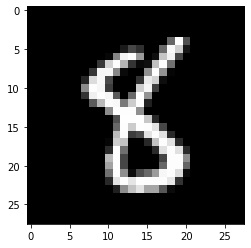

Closet audio labels Unimodal: [2, 5, 2, 2, 2]
Farthest audio labels Unimodal: [4, 3, 3, 3, 3]

Closest audio Unimodal:



Farthest audio Unimodal:


In [ ]:
index_search = 344 # play with this for more examples

top_5_uni, bottom_5_uni = perform_image_search(all_test_images[index_search], audio_embeddings, model=unimodal_image)


print(f"Closet audio labels Unimodal: {[all_test_audio_labels[i] for i in top_5_uni]}")
print(f"Farthest audio labels Unimodal: {[all_test_audio_labels[i] for i in bottom_5_uni]}")

print('')
print('Closest audio Unimodal:')

signal, sr = torchaudio.load(f'free-spoken-digit-dataset/recordings/{original_audio_filenames[top_5_uni[0]].replace(".png", ".wav")}')
ipd.display(ipd.Audio(signal[0], rate=sr))

print('')
print('Farthest audio Unimodal:')

signal, sr = torchaudio.load(f'free-spoken-digit-dataset/recordings/{original_audio_filenames[bottom_5_uni[-1]].replace(".png", ".wav")}')
ipd.display(ipd.Audio(signal[0], rate=sr))

Let's see how our multimodal models perform now.

Example image search


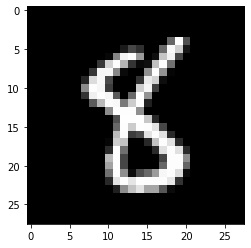

Closet audio labels Multimodal: [8, 8, 8, 8, 8]
Farthest audio labels Multimodal: [7, 7, 7, 7, 7]

Closest audio Multimodal:



Farthest audio Multimodal:


In [ ]:
index_search = 344

top_5_mm, bottom_5_mm = perform_image_search(all_test_images[index_search], audio_embeddings_mm, model=model_multimodal)

print(f"Closet audio labels Multimodal: {[all_test_audio_labels[i] for i in top_5_mm]}")
print(f"Farthest audio labels Multimodal: {[all_test_audio_labels[i] for i in bottom_5_mm]}")

print('')
print('Closest audio Multimodal:')

signal, sr = torchaudio.load(f'free-spoken-digit-dataset/recordings/{original_audio_filenames[top_5_mm[0]].replace(".png", ".wav")}')
ipd.display(ipd.Audio(signal[0], rate=sr))

print('')
print('Farthest audio Multimodal:')

signal, sr = torchaudio.load(f'free-spoken-digit-dataset/recordings/{original_audio_filenames[bottom_5_mm[-1]].replace(".png", ".wav")}')
ipd.display(ipd.Audio(signal[0], rate=sr))

Then, in the following section, we repeat, just now a recording->image process. As you can see, if the projection heads are not specifically trained to be in the same projection space, you can simply just give up.

Audio being searhced


Audio being searhced



Closet images Unimodal


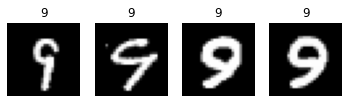


Farthest images Unimodal


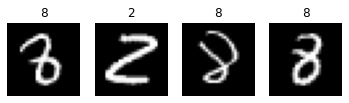

**************************************************

Closet images Multimodal


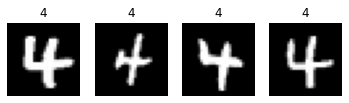


Farthest images Multimodal


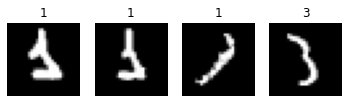

In [ ]:
index_search = 124

signal, _ = torchaudio.load(f'free-spoken-digit-dataset/recordings/{original_audio_filenames[index_search].replace(".png", ".wav")}', normalize=True)
top_5_mm, bottom_5_mm = perform_audio_search(all_test_audio[index_search], image_embeddings_mm, model=model_multimodal, audio=signal)
top_5_uni, bottom_5_uni = perform_audio_search(all_test_audio[index_search], image_embeddings, model=unimodal_speech, audio=signal)


print('')
print(f"Closet images Unimodal")
draw_mnist_subplots([[all_test_images[i][0], all_test_images_labels[i]] for i in top_5_uni])

print('')
print(f"Farthest images Unimodal")
draw_mnist_subplots([[all_test_images[i][0], all_test_images_labels[i]] for i in bottom_5_uni])

print('*'*50)

print('')
print(f"Closet images Multimodal")
draw_mnist_subplots([[all_test_images[i][0], all_test_images_labels[i]] for i in top_5_mm])

print('')
print(f"Farthest images Multimodal")
draw_mnist_subplots([[all_test_images[i][0], all_test_images_labels[i]] for i in bottom_5_mm])



### Excersises


1. Experiment with various distance metrics. Do some of them produce different outcomes? Why?

# Conclusion

This notebook hopefully piqued your interest in the field of representation learning, specifically the multimodal world of things. If you want to learn more, I recommend that you click on the links throughout the notebook. They will make excellent rabbit holes into which you can fall.

Otherwise, if you enjoy this type of work and want to join an exciting startup that is solving problems like these, please contact info@bytefuse.ai. We are happy to accept interns into our Llama program, and we are always looking for great people.